# EDA Analysis & Preprocessing

In [201]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from statsmodels.graphics.tsaplots import plot_acf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [202]:
# Load the dataset
df = pd.read_csv('/content/question4-stock-data.csv')
df.head()

,Unnamed: 0,Date,Adj Close,Close,High,Low,Open,Volume
0,0,1980-03-17,2.296798,3.291227,3.344743,3.291227,0.000000,41109.0
1,1,1980-03-18,2.306134,3.304606,3.358122,3.304606,0.000000,9343.0
2,2,1980-03-19,2.306134,3.304606,3.304606,3.304606,3.304606,0.0
3,3,1980-03-20,2.306134,3.304606,3.358122,3.304606,0.000000,10277.0
4,4,1980-03-21,2.362154,3.384880,3.438396,3.384880,0.000000,8409.0


In [203]:
#dropping unnecessary columns
df = df.drop('Unnamed: 0', axis=1)

In [204]:
df.shape

(11291, 7)

In [205]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11291 entries, 0 to 11290
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       11181 non-null  object 
 1   Adj Close  11198 non-null  float64
 2   Close      11174 non-null  float64
 3   High       11196 non-null  float64
 4   Low        11164 non-null  float64
 5   Open       11188 non-null  float64
 6   Volume     11146 non-null  float64
dtypes: float64(6), object(1)
memory usage: 617.6+ KB


In [206]:
# Convert 'Date' column to datetime objects
df['Date'] = pd.to_datetime(df['Date'])

In [207]:
df.describe()

,Date,Adj Close,Close,High,Low,Open,Volume
count,11181,11198.000000,11174.000000,11196.000000,11164.000000,11188.000000,1.114600e+04
mean,2002-08-03 13:57:54.429836288,63.609130,72.026945,72.503100,71.665079,67.999259,2.144157e+05
min,1980-03-17 00:00:00,2.259452,3.237711,3.237711,3.237711,0.000000,0.000000e+00
25%,1991-05-17 00:00:00,19.224636,27.500000,27.789255,27.536156,0.000000,1.350000e+04
50%,2002-07-26 00:00:00,50.608900,66.035000,66.724998,65.418751,66.065002,9.032350e+04
75%,2013-10-21 00:00:00,104.723621,114.297503,114.892500,113.639999,114.269997,2.915750e+05
max,2024-12-27 00:00:00,254.770004,254.770004,255.229996,253.589996,255.000000,1.858270e+07
std,NaN,52.266247,51.259828,51.550735,51.011632,55.834401,3.883662e+05


In [208]:
df.isnull().sum()

,0
Date,110
Adj Close,93
Close,117
High,95
Low,127
Open,103
Volume,145


In [209]:
# Drop rows where 'Date' is missing
df = df.dropna(subset=['Date'])

# Sort by 'Date'
df = df.sort_values('Date')

In [210]:
# Forward fill missing values for price and volume columns
columns_to_fill = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
df[columns_to_fill] = df[columns_to_fill].fillna(method='ffill')

<ipython-input-210-278e21534d75>:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[columns_to_fill] = df[columns_to_fill].fillna(method='ffill')


## Feature Engineering

In [211]:
# Create the target variable (Close price 5 days ahead)
df['Target'] = df['Close'].shift(-5)

# Drop rows where 'Target' is NaN
df = df.dropna(subset=['Target'])

In [212]:
# function to create rolling features
def create_rolling_features(df, window_size):
    df['Rolling_Mean'] = df['Close'].rolling(window=window_size).mean()
    df.dropna(inplace=True)
    return df

# Create rolling features with a window size of 10
window_size = 20
df = create_rolling_features(df, window_size)

In [213]:
#Price range
df['Price_Range'] = df['High'] - df['Low']

In [214]:
df.head()

,Date,Adj Close,Close,High,Low,Open,Volume,Target,Rolling_Mean,Price_Range
19,1980-04-14,2.352816,3.371501,3.371501,3.371501,3.371501,0.0,3.425017,3.319323,0.000000
20,1980-04-15,2.427510,3.478533,3.532049,3.371501,0.000000,1869.0,3.425017,3.328688,0.160548
21,1980-04-16,2.427510,3.478533,3.532049,3.478533,0.000000,61664.0,3.491912,3.337385,0.053516
22,1980-04-17,2.427510,3.478533,3.478533,3.478533,3.478533,0.0,3.518670,3.346081,0.000000
23,1980-04-18,2.390163,3.425017,3.478533,3.425017,0.000000,1869.0,3.545428,3.352101,0.053516


In [215]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11157 entries, 19 to 11285
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          11157 non-null  datetime64[ns]
 1   Adj Close     11157 non-null  float64       
 2   Close         11157 non-null  float64       
 3   High          11157 non-null  float64       
 4   Low           11157 non-null  float64       
 5   Open          11157 non-null  float64       
 6   Volume        11157 non-null  float64       
 7   Target        11157 non-null  float64       
 8   Rolling_Mean  11157 non-null  float64       
 9   Price_Range   11157 non-null  float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 958.8 KB


## Handling Missing values

In [216]:
# calculating if there are any values equal to 0
for col in df.columns:
    zero_count = (df[col] == 0).sum()
    print(f"Zeros in {col}: {zero_count}")

Zeros in Date: 0
Zeros in Adj Close: 0
Zeros in Close: 0
Zeros in High: 0
Zeros in Low: 0
Zeros in Open: 2932
Zeros in Volume: 128
Zeros in Target: 0
Zeros in Rolling_Mean: 0
Zeros in Price_Range: 140


In [217]:
#forward fill the 0 values
for col in df.columns:
    df[col] = df[col].replace(0).fillna(method='ffill')

<ipython-input-217-69d4e140cc40>:3: FutureWarning: Series.replace without 'value' and with non-dict-like 'to_replace' is deprecated and will raise in a future version. Explicitly specify the new values instead.
  df[col] = df[col].replace(0).fillna(method='ffill')
<ipython-input-217-69d4e140cc40>:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].replace(0).fillna(method='ffill')


In [218]:
for col in df.columns:
    zero_count = (df[col] == 0).sum()
    print(f"Zeros in {col}: {zero_count}")

Zeros in Date: 0
Zeros in Adj Close: 0
Zeros in Close: 0
Zeros in High: 0
Zeros in Low: 0
Zeros in Open: 0
Zeros in Volume: 1
Zeros in Target: 0
Zeros in Rolling_Mean: 0
Zeros in Price_Range: 1


In [219]:
df.head()

,Date,Adj Close,Close,High,Low,Open,Volume,Target,Rolling_Mean,Price_Range
19,1980-04-14,2.352816,3.371501,3.371501,3.371501,3.371501,0.0,3.425017,3.319323,0.000000
20,1980-04-15,2.427510,3.478533,3.532049,3.371501,3.371501,1869.0,3.425017,3.328688,0.160548
21,1980-04-16,2.427510,3.478533,3.532049,3.478533,3.371501,61664.0,3.491912,3.337385,0.053516
22,1980-04-17,2.427510,3.478533,3.478533,3.478533,3.478533,61664.0,3.518670,3.346081,0.053516
23,1980-04-18,2.390163,3.425017,3.478533,3.425017,3.478533,1869.0,3.545428,3.352101,0.053516


In [220]:
# Replace 0 values in 'Open' column with the previous day's 'Close' price
df['Open'] = df['Open'].replace(0, np.nan)
df['Open'] = df['Open'].fillna(df['Close'].shift(1))


In [221]:
df.head()

,Date,Adj Close,Close,High,Low,Open,Volume,Target,Rolling_Mean,Price_Range
19,1980-04-14,2.352816,3.371501,3.371501,3.371501,3.371501,0.0,3.425017,3.319323,0.000000
20,1980-04-15,2.427510,3.478533,3.532049,3.371501,3.371501,1869.0,3.425017,3.328688,0.160548
21,1980-04-16,2.427510,3.478533,3.532049,3.478533,3.371501,61664.0,3.491912,3.337385,0.053516
22,1980-04-17,2.427510,3.478533,3.478533,3.478533,3.478533,61664.0,3.518670,3.346081,0.053516
23,1980-04-18,2.390163,3.425017,3.478533,3.425017,3.478533,1869.0,3.545428,3.352101,0.053516


In [222]:
#dropping the first row
df = df.iloc[1:]

In [223]:
df.head()

,Date,Adj Close,Close,High,Low,Open,Volume,Target,Rolling_Mean,Price_Range
20,1980-04-15,2.427510,3.478533,3.532049,3.371501,3.371501,1869.0,3.425017,3.328688,0.160548
21,1980-04-16,2.427510,3.478533,3.532049,3.478533,3.371501,61664.0,3.491912,3.337385,0.053516
22,1980-04-17,2.427510,3.478533,3.478533,3.478533,3.478533,61664.0,3.518670,3.346081,0.053516
23,1980-04-18,2.390163,3.425017,3.478533,3.425017,3.478533,1869.0,3.545428,3.352101,0.053516
24,1980-04-21,2.390163,3.425017,3.478533,3.425017,3.478533,5606.0,3.585565,3.354108,0.053516


In [224]:
for col in df.columns:
    zero_count = (df[col] == 0).sum()
    print(f"Zeros in {col}: {zero_count}")

Zeros in Date: 0
Zeros in Adj Close: 0
Zeros in Close: 0
Zeros in High: 0
Zeros in Low: 0
Zeros in Open: 0
Zeros in Volume: 0
Zeros in Target: 0
Zeros in Rolling_Mean: 0
Zeros in Price_Range: 0


In [225]:
#columns in the new dataframe
df.columns

Index(['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'Target',
       'Rolling_Mean', 'Price_Range'],
      dtype='object')

In [226]:
df.head()

,Date,Adj Close,Close,High,Low,Open,Volume,Target,Rolling_Mean,Price_Range
20,1980-04-15,2.427510,3.478533,3.532049,3.371501,3.371501,1869.0,3.425017,3.328688,0.160548
21,1980-04-16,2.427510,3.478533,3.532049,3.478533,3.371501,61664.0,3.491912,3.337385,0.053516
22,1980-04-17,2.427510,3.478533,3.478533,3.478533,3.478533,61664.0,3.518670,3.346081,0.053516
23,1980-04-18,2.390163,3.425017,3.478533,3.425017,3.478533,1869.0,3.545428,3.352101,0.053516
24,1980-04-21,2.390163,3.425017,3.478533,3.425017,3.478533,5606.0,3.585565,3.354108,0.053516


## EDA

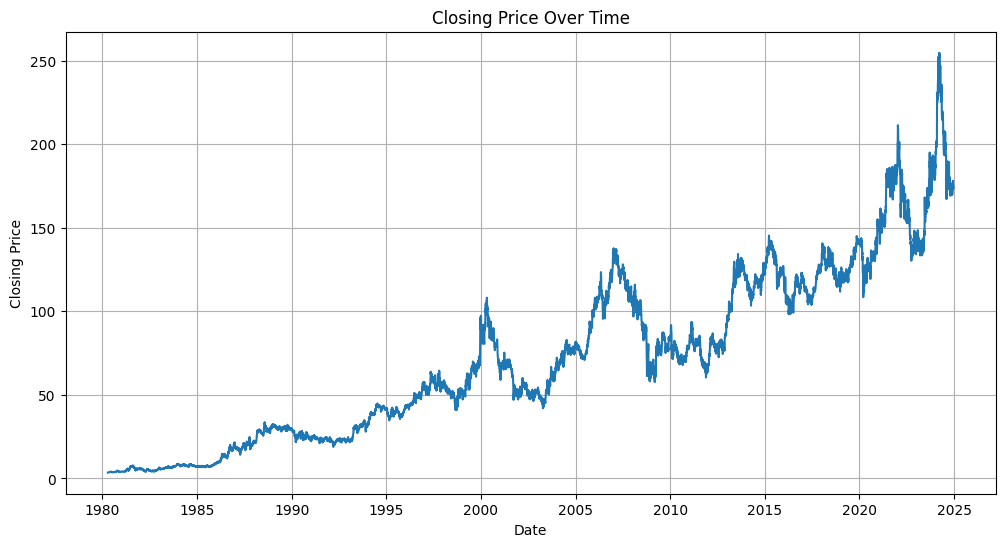

In [227]:
#plot the closing price according to the time

plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'])
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Closing Price Over Time')
plt.grid(True)
plt.show()


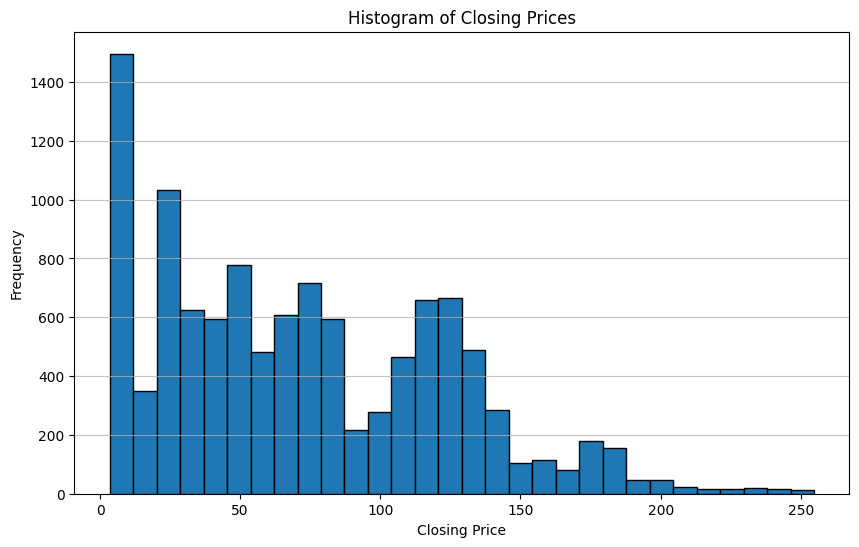

In [228]:
# prompt: Create a histogram (a bar chart) to show how often certain prices happen

plt.figure(figsize=(10, 6))
plt.hist(df['Close'], bins=30, edgecolor='black')
plt.xlabel('Closing Price')
plt.ylabel('Frequency')
plt.title('Histogram of Closing Prices')
plt.grid(axis='y', alpha=0.75)
plt.show()


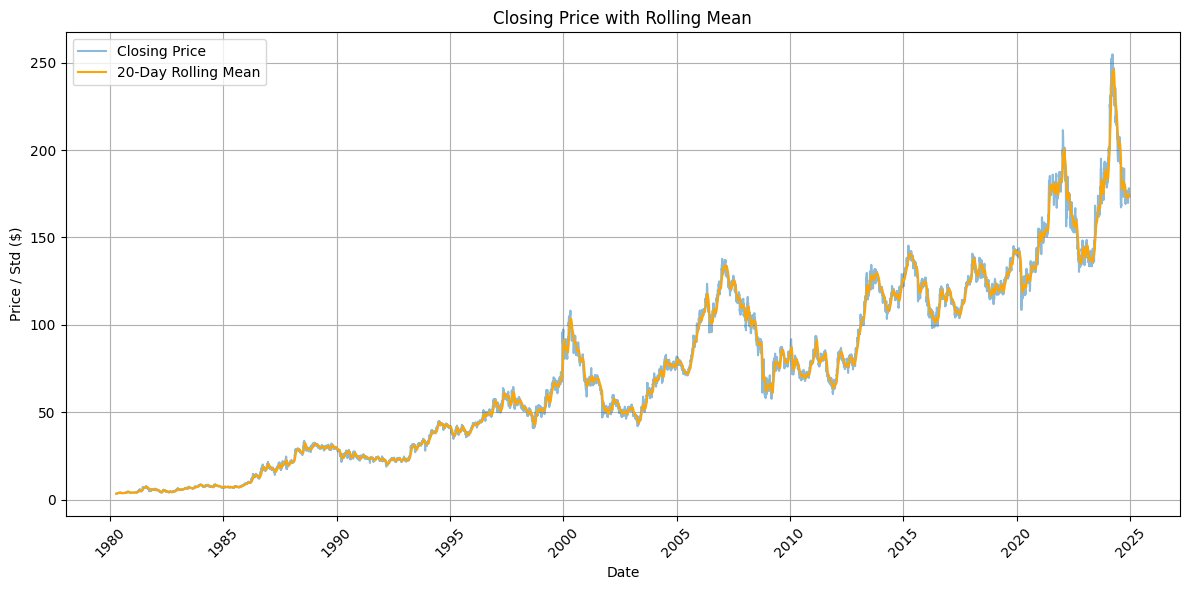

In [229]:
#Closing Price with Rolling Mean

plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'], label='Closing Price', alpha=0.5)
plt.plot(df['Date'], df['Rolling_Mean'], label='20-Day Rolling Mean', color='orange')
plt.xlabel('Date')
plt.ylabel('Price / Std ($)')
plt.title('Closing Price with Rolling Mean')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

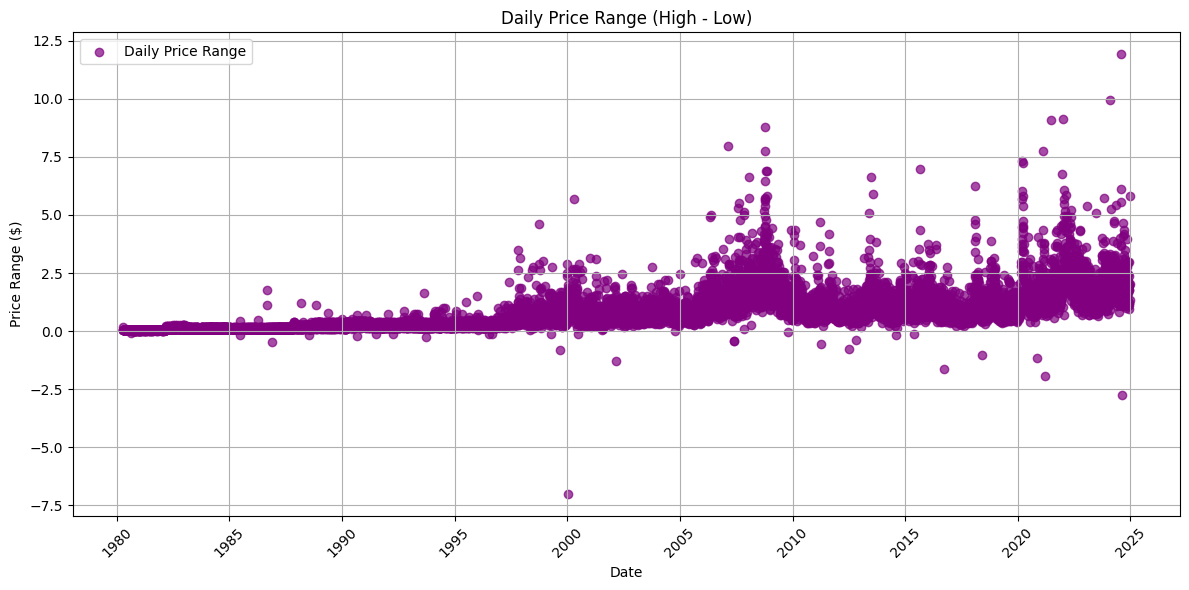

In [230]:
#daily price range

plt.figure(figsize=(12, 6))
plt.scatter(df['Date'], df['Price_Range'], color='purple', label='Daily Price Range', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Price Range ($)')
plt.title('Daily Price Range (High - Low)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


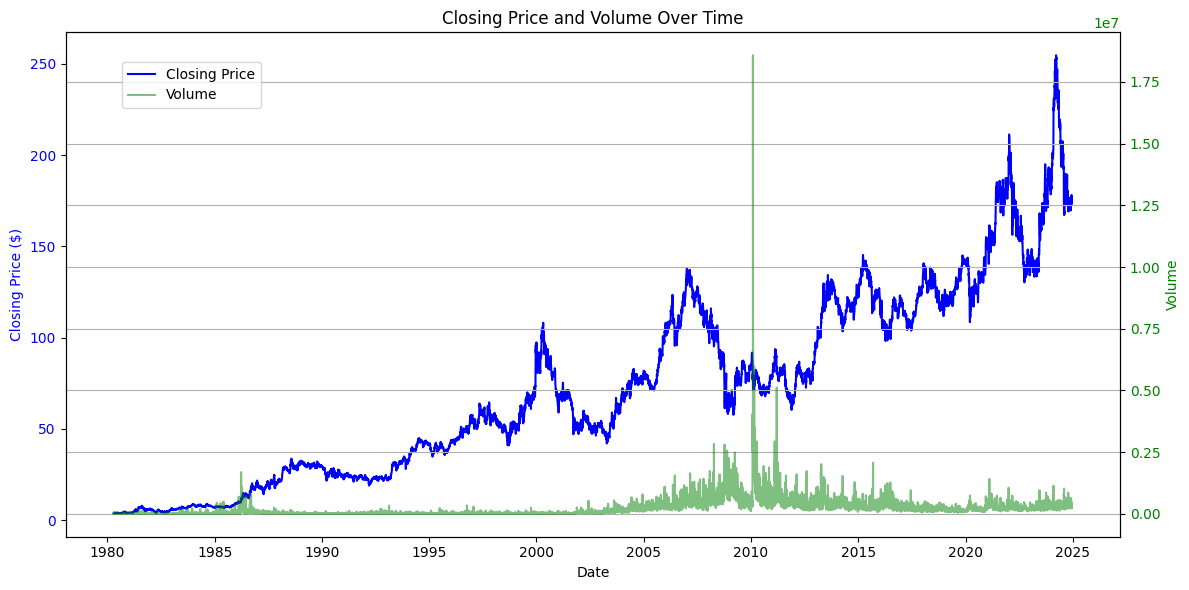

In [231]:
#Closing Price and Volume Over Time

fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(df['Date'], df['Close'], color='blue', label='Closing Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('Closing Price ($)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(df['Date'], df['Volume'], color='green', label='Volume', alpha=0.5)
ax2.set_ylabel('Volume', color='green')
ax2.tick_params(axis='y', labelcolor='green')

plt.title('Closing Price and Volume Over Time')
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<ipython-input-232-eaacb12ff8ca>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Year', y='Close', data=df, palette='Blues')


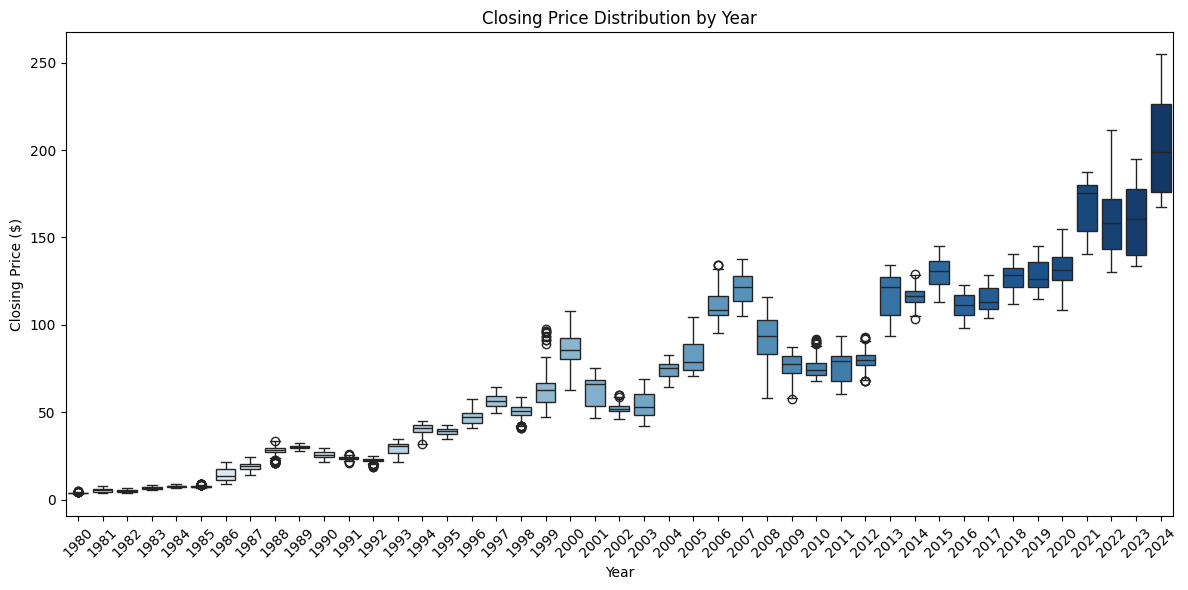

In [232]:
#Closing Price Distribution by Year

df['Year'] = df['Date'].dt.year
plt.figure(figsize=(12, 6))
sns.boxplot(x='Year', y='Close', data=df, palette='Blues')
plt.xlabel('Year')
plt.ylabel('Closing Price ($)')
plt.title('Closing Price Distribution by Year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

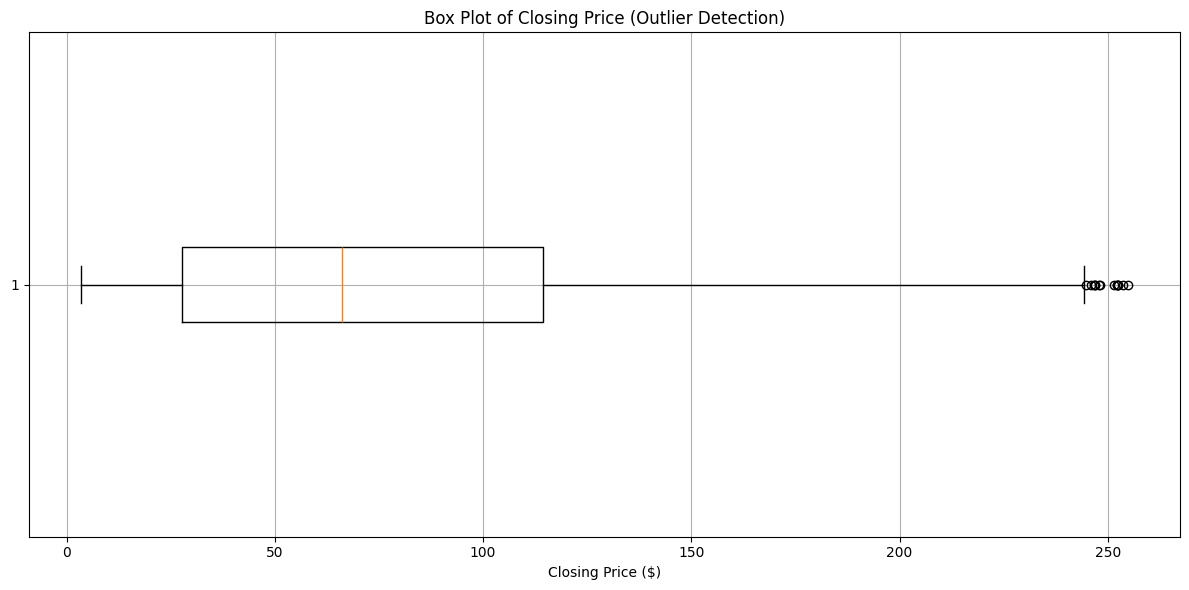

In [233]:
#Box Plot of Closing Price (Outlier Detection)

plt.figure(figsize=(12, 6))
plt.boxplot(df['Close'], vert=False)
plt.xlabel('Closing Price ($)')
plt.title('Box Plot of Closing Price (Outlier Detection)')
plt.grid(True)
plt.tight_layout()
plt.show()

## Outliers

In [234]:
# Calculate IQR for 'Close' price
Q1 = df['Close'].quantile(0.25)
Q3 = df['Close'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR



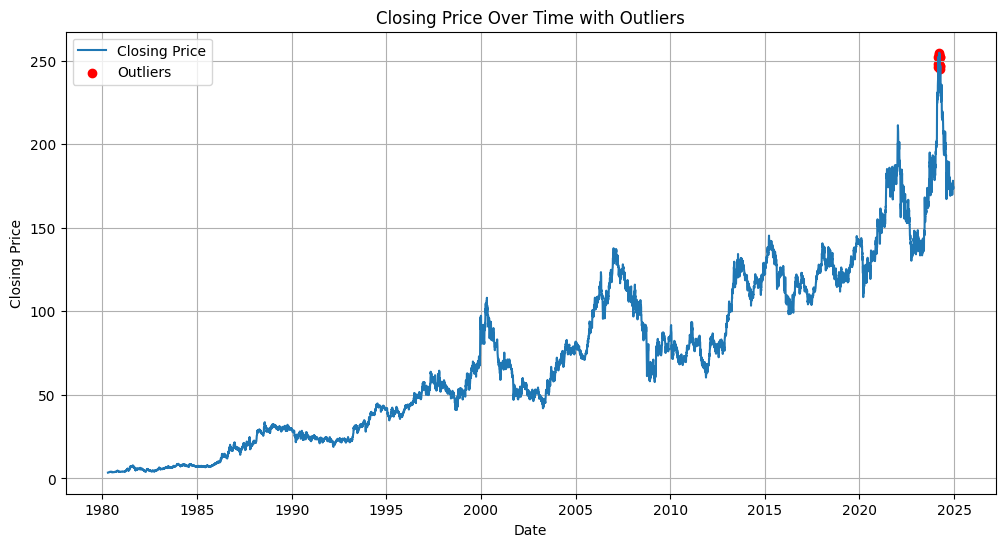

In [235]:
# Identify outliers
outliers = df[(df['Close'] < lower_bound) | (df['Close'] > upper_bound)]


# Visualize outliers (optional)
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'], label='Closing Price')
plt.scatter(outliers['Date'], outliers['Close'], color='red', label='Outliers')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Closing Price Over Time with Outliers')
plt.legend()
plt.grid(True)
plt.show()

In [236]:
# Print or visualize outliers
print("Number of outliers:", len(outliers))
print("Outliers:")
print(outliers)


Number of outliers: 14
Outliers:
            Date   Adj Close       Close        High         Low        Open  \
11082 2024-03-01  246.039993  246.039993  246.539993  244.559998  244.660004   
11084 2024-03-05  248.190002  248.190002  249.990005  246.809998  247.710007   
11085 2024-03-06  252.399994  252.399994  253.429993  250.929993  252.149994   
11086 2024-03-07  247.940002  247.940002  248.050003  245.699997  246.929993   
11095 2024-03-20  246.720001  246.720001  246.800003  244.309998  244.679993   
11096 2024-03-21  251.479996  251.479996  251.789993  250.259995  251.449997   
11097 2024-03-22  254.770004  254.770004  255.229996  253.589996  255.000000   
11098 2024-03-25  252.410004  252.410004  253.419998  251.039993  252.110001   
11099 2024-03-26  253.720001  253.720001  254.789993  253.389999  253.889999   
11100 2024-03-27  252.149994  252.149994  254.199997  250.330002  253.699997   
11101 2024-03-28  251.679993  252.149994  252.850006  251.139999  251.139999   
11108 2

We decided to keep the outlier hence there are only 14 and removing them will affect the sequential flow of the model

In [237]:
df.columns

Index(['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'Target',
       'Rolling_Mean', 'Price_Range', 'Year'],
      dtype='object')

In [238]:
features = df[['Open', 'High', 'Low', 'Close', 'Volume', 'Rolling_Mean', 'Price_Range']]
target = df['Target']

In [239]:
df.head()

,Date,Adj Close,Close,High,Low,Open,Volume,Target,Rolling_Mean,Price_Range,Year
20,1980-04-15,2.427510,3.478533,3.532049,3.371501,3.371501,1869.0,3.425017,3.328688,0.160548,1980
21,1980-04-16,2.427510,3.478533,3.532049,3.478533,3.371501,61664.0,3.491912,3.337385,0.053516,1980
22,1980-04-17,2.427510,3.478533,3.478533,3.478533,3.478533,61664.0,3.518670,3.346081,0.053516,1980
23,1980-04-18,2.390163,3.425017,3.478533,3.425017,3.478533,1869.0,3.545428,3.352101,0.053516,1980
24,1980-04-21,2.390163,3.425017,3.478533,3.425017,3.478533,5606.0,3.585565,3.354108,0.053516,1980


## Scaling

In [240]:
df = df.set_index('Date')  # Set Date as index
features = ['Open', 'High', 'Low', 'Close', 'Volume','Rolling_Mean', 'Price_Range']
target = 'Target'

# Normalize features and target separately
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()
df_scaled = pd.DataFrame(scaler_features.fit_transform(df[features]),
                        columns=features, index=df.index)
df_scaled[target] = scaler_target.fit_transform(df[[target]])

In [241]:
df_scaled.head()

,Open,High,Low,Close,Volume,Rolling_Mean,Price_Range,Target
Date,,,,,,,,
1980-04-15,0.000000,0.000425,0.000000,0.000213,0.000095,0.000000,0.378665,0.000000
1980-04-16,0.000000,0.000425,0.000428,0.000213,0.003312,0.000036,0.373004,0.000266
1980-04-17,0.000425,0.000213,0.000428,0.000213,0.003312,0.000072,0.373004,0.000373
1980-04-18,0.000425,0.000213,0.000214,0.000000,0.000095,0.000097,0.373004,0.000479
1980-04-21,0.000425,0.000213,0.000214,0.000000,0.000296,0.000105,0.373004,0.000639


In [242]:
def create_sequences(data, seq_length, target_col):
    X, y = [], []
    for i in range(len(data) - seq_length - 5):  # -5 for target shift
        X.append(data.iloc[i:i+seq_length][features].values)
        y.append(data.iloc[i+seq_length+4][target_col])  # +4 because 5th day is t+5
    return np.array(X), np.array(y)

seq_length = 10  # 20-day lookback
X, y = create_sequences(df_scaled, seq_length, target)
print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (11141, 10, 7), y shape: (11141,)


In [243]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
print(f"Train samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")

Train samples: 8912, Test samples: 2229


# Model Creation and Evaluation

In [244]:
model = Sequential()
model.add(LSTM(100, activation='tanh', input_shape=(seq_length, len(features)), return_sequences=True))
model.add(LSTM(50, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(20, activation='relu'))
model.add(Dense(1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [245]:
model.compile(optimizer=Adam(learning_rate=0.001, clipnorm=1.0), loss='mse')

In [246]:
# Train
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=200, batch_size=32,
                    validation_split=0.2, callbacks=[early_stopping], verbose=1)

Epoch 1/200
223/223 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.0052 - val_loss: 3.5965e-04
Epoch 2/200
223/223 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 4.3963e-04 - val_loss: 3.5928e-04
Epoch 3/200
223/223 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 3.8482e-04 - val_loss: 6.1938e-04
Epoch 4/200
223/223 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 3.4466e-04 - val_loss: 8.4785e-04
Epoch 5/200
223/223 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 3.6970e-04 - val_loss: 3.7695e-04
Epoch 6/200
223/223 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 2.8024e-04 - val_loss: 9.0804e-04
Epoch 7/200
223/223 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 2.8360e-04 - val_loss: 4.3356e-04
Epoch 8/200
223/223 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 2.5444e-04 - val_loss: 5.2969e-04
Epoch 9/200
223/223 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 2.6840e-04 - val_loss: 5.1008e-04
Epoch 10/200
223/223 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 2.4468e-04 - val_loss: 7.6877e-04
Epoch 11/200
223/223 ━━━━━━━━━━━━━━━━━━━━ 

In [247]:
# Evaluate
y_pred_scaled = model.predict(X_test)
y_test_unscaled = scaler_target.inverse_transform(y_test.reshape(-1, 1))
y_pred_unscaled = scaler_target.inverse_transform(y_pred_scaled)
rmse = np.sqrt(mean_squared_error(y_test_unscaled, y_pred_unscaled))
directional_accuracy = np.mean(np.sign(y_test_unscaled[1:] - y_test_unscaled[:-1]) ==
                              np.sign(y_pred_unscaled[1:] - y_pred_unscaled[:-1])) * 100
print(f"RMSE: {rmse}, Directional Accuracy: {directional_accuracy:.2f}%")

70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
RMSE: 7.6205592820058, Directional Accuracy: 49.60%


In [248]:
# Ensemble with baseline
current_prices = df['Close'].iloc[train_size + seq_length + 4:train_size + seq_length + 4 + len(y_test)].values
y_pred_ensemble = (y_pred_unscaled + current_prices.reshape(-1, 1)) / 2
rmse_ensemble = np.sqrt(mean_squared_error(y_test_unscaled, y_pred_ensemble))
directional_accuracy_ensemble = np.mean(np.sign(y_test_unscaled[1:] - y_test_unscaled[:-1]) ==
                                       np.sign(y_pred_ensemble[1:] - y_pred_ensemble[:-1])) * 100
print(f"Ensemble RMSE: {rmse_ensemble}, Directional Accuracy: {directional_accuracy_ensemble:.2f}%")

Ensemble RMSE: 5.687358481516186, Directional Accuracy: 47.17%


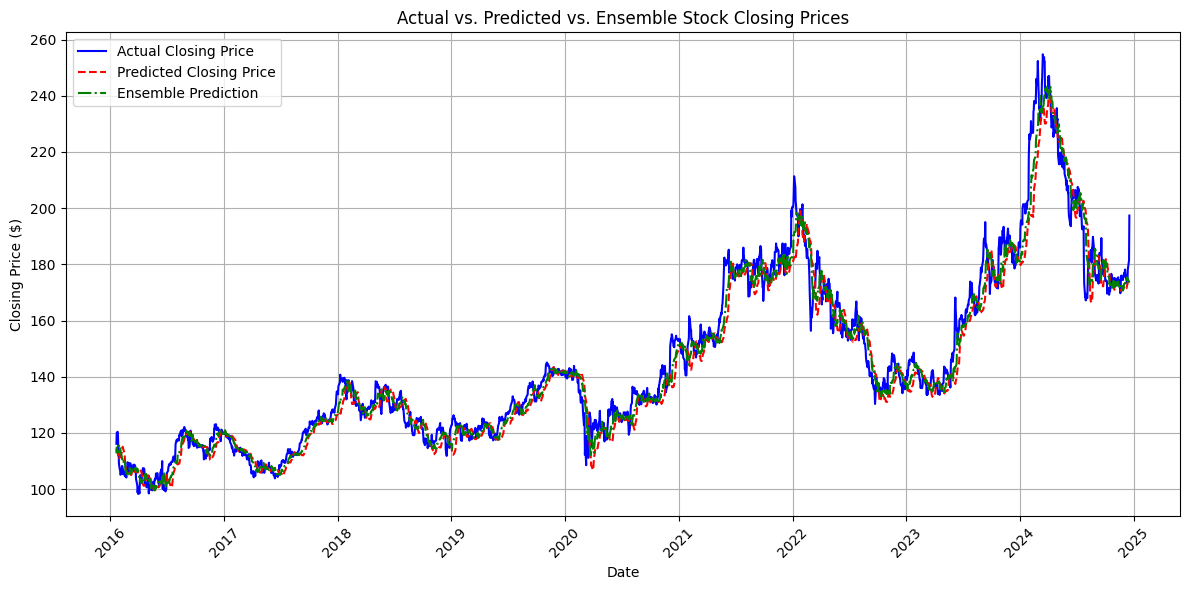

In [249]:
# Plot
test_dates = df.index[train_size + seq_length + 4:train_size + seq_length + 4 + len(y_test)]
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_unscaled, label='Actual Closing Price', color='blue')
plt.plot(test_dates, y_pred_unscaled, label='Predicted Closing Price', color='red', linestyle='--')
plt.plot(test_dates, y_pred_ensemble, label='Ensemble Prediction', color='green', linestyle='-.')
plt.xlabel('Date')
plt.ylabel('Closing Price ($)')
plt.title('Actual vs. Predicted vs. Ensemble Stock Closing Prices')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()